# Goal:--  
Build a model that accepts a low resolution image and generates a high resoltuion image.

In [0]:
##Necessary imports 
import tensorflow as tf
import keras
import numpy as np
from scipy.misc import imresize
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [0]:
##Loading the dataset
from keras.datasets import mnist
(X_train,y_train),(X_test,y_test) = mnist.load_data()
print("DataSet is loaded")

DataSet is loaded


## Model Description  
For the given goal we are going to use an **CONVOLUTIONAL AUTOENCODER** a variation of autoencoder.  
An autoencoder is combination of two parts : **an encoder and a deocder.**  . The encoder and decoder of a simple autoencoder are mae up of **DENSE** layers, whereas in a conv_autoencoder,they are made up of **CONVOLUTIONAL LAYERS.**  


The Encoder part of the AE accpets the image and compreses it to a smaller size with the help of **POOLING** operation.(**MAX-POOLING**)(**also called as DOWNSAMPLEING**).  
The Decoder part of the AE accpetes the encoded image and learns to **EXPAND** the image to the desired size by using **CONVOLUTION AND UPSAMPLING** operation.  
![alt text](https://cdn-images-1.medium.com/max/2000/1*XPxFuQLXyERecIoEQtYQWQ.png)    


### Additional Note:--   
BottleNeck layer is really important, it can be used in   
1) Dimensionality Reduction (data compression)   
2) Anamoly Detection  
3) In image Reconstruction.  
And many more use cases.


Just Extract the bottle neck layer and use it the way you want!!!!   





## Data Preprocessing  
To generate low resolution images ,defining a function call im_reshape() that will resize the input image to the descire dimension.  
**Input_Dimension =  (14,14)**  
**Output_Dimension = (28,28)**  

In [0]:
def im_reshape(x):
  """ Reshaping the images to 14*14 shape"""
  img = imresize(x.reshape(28,28),(14,14))
  return img

##creatig the low resolution images
xx_train = np.array([*map(im_reshape,X_train.astype(float))])
xx_test = np.array([*map(im_reshape,X_test.astype(float))])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


## Scaling   
This is done to make the training process faster.

In [0]:
##scaling between 0 and 1

##Input(14*14)
xx_train = xx_train/255.0
xx_test  = xx_test/255.0

##output(28*28)
X_train = X_train/255.0
X_test = X_test/255.0

## Model Definition  
***Encoder***  


*   The first layer is a **2D conv** layer with **64 filters** and having  **3*3 kernel size**  followed by ** batch normalization** and **relu activation**,next ** downsampling with 2*2 filters and stride of 2**.
*   In the second layer we just change the number of filters to 128 rest keeping same.

***Decoder***  


*   The first layer is a 2D conv layer with 128 filters of size 3*3 with relu activation, followed by upsampling.
*   **Last layer is 2D conv layer with 1 filter of size 3*3 with activation as sigmoid.**   


**NOTE** :--   
                      Decoder is bascially mirror image of the Encoder with slight differences.





In [0]:
##Hyperparameters
batch_size = 128
epochs = 50
input_shape = (14,14,1)  # width,height,depth

In [0]:
##necessary imports
from keras.layers import Conv2D,MaxPooling2D,UpSampling2D
from keras.models import Model,Sequential
from keras.optimizers import Adam
from keras import backend as k

In [0]:
##defining the model
def conv_autoencoder(input_shape):
  """
  This function includes the model architecture.
  1) Encoder
  2) Decoder
  """
  
  ##defining the Encoder
  
  ##layer-1
  input_data = keras.layers.Input(shape = input_shape,dtype = 'float32')
  ##adding 2D conv layer
  conv1 = Conv2D(64,(3,3),activation = 'relu',padding = 'same')(input_data)
  ##max pooling operation
  conv_pooled1 = MaxPooling2D(pool_size = (2,2))(conv1)
  ##batch normalization
  conv_batch1 = keras.layers.BatchNormalization()(conv_pooled1)
  
  
  ##layer-2
  conv2 = Conv2D(128,(3,3),activation = 'relu',padding = 'same')(conv_batch1)
  conv_batch2 = keras.layers.BatchNormalization()(conv2)
  
  
  ##defining the Decoder part
  ##decoder layer-1
  conv_dec1 = Conv2D(128,(3,3),activation = 'relu',padding = 'same')(conv_batch2)
  conv_dec1 = UpSampling2D((2,2))(conv_dec1)
  conv_dec_batch1 = keras.layers.BatchNormalization()(conv_dec1)
  
  ##decoder layer -02
  conv_dec2 = Conv2D(64,(3,3),activation = 'relu',padding = 'same')(conv_dec_batch1)
  conv_dec2 = UpSampling2D((2,2))(conv_dec2)
  conv_dec_batch2 = keras.layers.BatchNormalization()(conv_dec2)
  
  ##Adding the final layer
  dec_output = Conv2D(1,(3,3),activation = 'sigmoid',padding = 'same')(conv_dec_batch2)
  
  return input_data,dec_output




In [0]:
##calling the Model from keras

input_data,dec_output = conv_autoencoder(input_shape)
model = Model(inputs = [input_data],output = [dec_output])

##compiling the model
model.compile(loss = 'mean_squared_error',
             optimizer = Adam(lr = 0.002))

##getting the summary of the model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 14, 14, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         147584    
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  This is separate from the ipykernel package so we can avoid doing imports until


## Fitting The Conv-AutoEncoder

In [0]:
history = model.fit(xx_train.reshape(-1,14,14,1),
                   X_train.reshape(-1,28,28,1),
                   batch_size = batch_size,
                   epochs = epochs,
                   verbose = 1,
                   validation_split = 0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 15s 322us/step - loss: 0.0128 - val_loss: 0.0042
Epoch 2/50
48000/48000 [==============================] - 14s 290us/step - loss: 0.0029 - val_loss: 0.0025
Epoch 3/50
48000/48000 [==============================] - 14s 289us/step - loss: 0.0023 - val_loss: 0.0023
Epoch 4/50
48000/48000 [==============================] - 14s 289us/step - loss: 0.0020 - val_loss: 0.0018
Epoch 5/50
48000/48000 [==============================] - 14s 290us/step - loss: 0.0019 - val_loss: 0.0019
Epoch 6/50
48000/48000 [==============================] - 14s 289us/step - loss: 0.0017 - val_loss: 0.0017
Epoch 7/50
48000/48000 [==============================] - 14s 289us/step - loss: 0.0016 - val_loss: 0.0017
Epoch 8/50
48000/48000 [==============================] - 14s 289us/step - loss: 0.0016 - val_loss: 0.0024
Epoch 9/50
48000/48000 [==============================] - 14s 288us/step - loss: 0.0024 - val_

## Loss Plot and Test Results

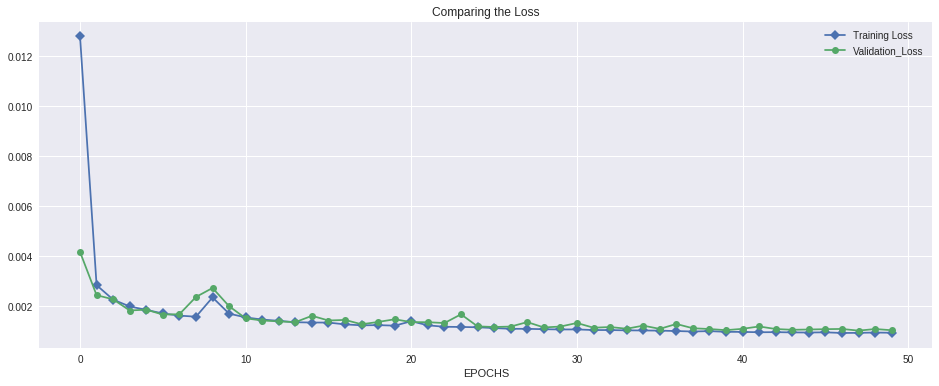

In [0]:
##getting loss
loss = history.history['loss']
##getting the validation loss
val_loss = history.history['val_loss']
##getting the epochs for plotting on the x-axis
x_points = list(range(epochs))
plt.figure(figsize = (16,6))

##plotting
plt.plot(x_points,loss,marker = 'D',label = 'Training Loss')
plt.plot(x_points,val_loss,marker = 'o',label = 'Validation_Loss')
plt.xlabel("EPOCHS")
plt.title("Comparing the Loss")
plt.legend()
plt.show()

# Model Inference

Input Images


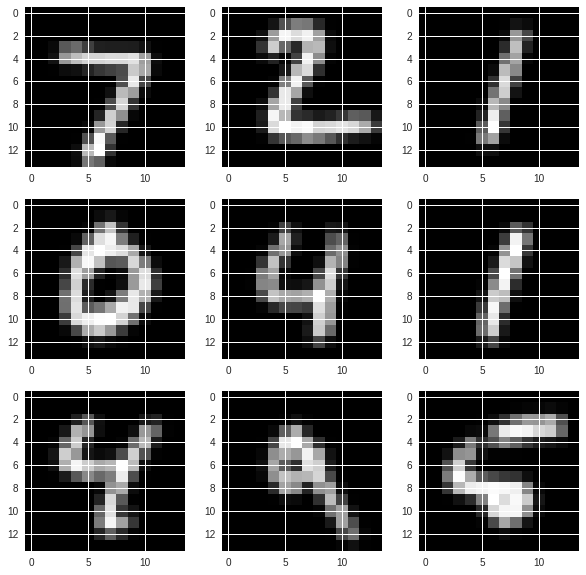

In [0]:
print("Input Images")

plt.figure(figsize = (10,10))
for i in range(9):
  plt.subplot(331+i)
  plt.imshow(np.squeeze(xx_test.reshape(-1,14,14,1)[i]),cmap = 'gray')
plt.show()




Generated Images


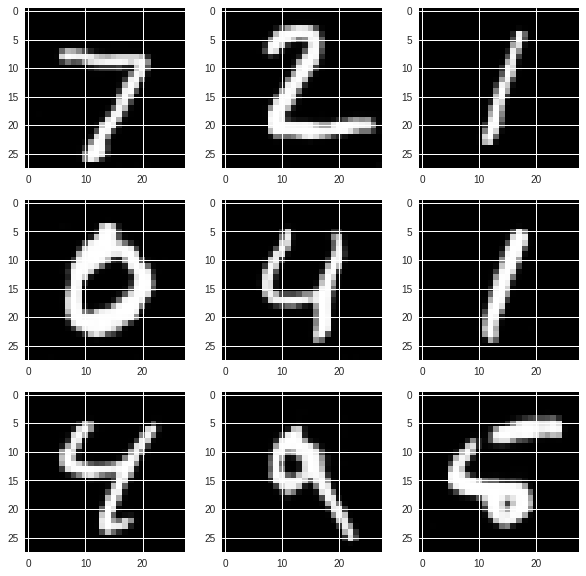

In [0]:
print("Generated Images")
plt.figure(figsize = (10,10))
for i in range(9):
  plt.subplot(331+i)
  pred = model.predict(xx_test.reshape(-1,14,14,1)[i:i+1],verbose = 0)
  plt.imshow(pred[0].reshape(28,28),cmap = 'gray')
plt.show()

**Thanks **  
 